In [1]:
import functions_idealized
import functions_grid
import functions_realistic
import scipy as sc, scipy.io
import numpy as np
import matplotlib.cm as cm
import colormap_ibcao
import cmocean as cmo

import matplotlib.pyplot as plt
%matplotlib inline

# Set up

In [2]:
ibcao_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x_ibcao = ibcao_file.variables['x'][:]
y_ibcao = ibcao_file.variables['y'][:]
z_ibcao = ibcao_file.variables['z'][:]
xl=-1750e3; xr=-1050e3; yb=1300e3; yt=2000e3
xmin = np.where(x_ibcao==xl)[0][0]
xmax = np.where(x_ibcao==xr)[0][0]
ymin = np.where(y_ibcao==yb)[0][0]
ymax = np.where(y_ibcao==yt)[0][0]
x_region = x_ibcao[xmin:xmax]
y_region = y_ibcao[ymin:ymax]
z_region = z_ibcao[ymin:ymax, xmin:xmax]

In [36]:
extension = 20
x_orig = 120
y_orig = int(0.75 * x_orig)
search_x = [-1100000, -1450000, -1750000, -1400000]

smooth_factor = 0.2
max_norm_depth_diff = 0.70834736504

x_orig, y_orig

(120, 90)

# 1. Mackenzie Canyon Dimensions

In [4]:
w_break, w_mid, w_head, width_f, x_wall, mouth, length, y_wall_1300, y_wall, adjust, cR, L, y_base, y_break,\
y_coast, y_head, fluid_depth, z_bottom, z_break, z_wall, p = functions_idealized.define_Mackenzie_measurements()

# 2. Domain Boundaries

In [5]:
lon_s_corners, lat_s_corners = functions_grid.match_domain(x_wall, y_wall, search_x)

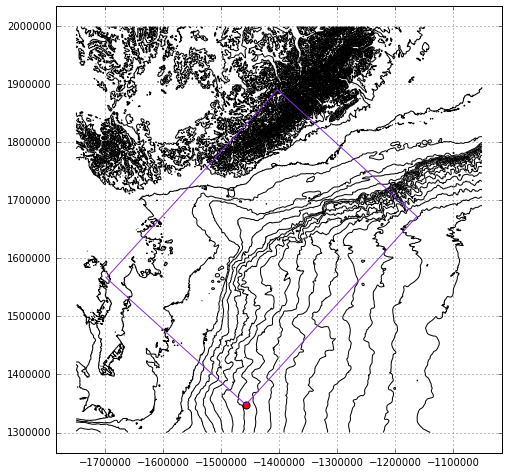

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')

ax.plot(lon_s_corners, lat_s_corners, 'BlueViolet')
ax.plot(lon_s_corners[0::3], lat_s_corners[0::3], 'BlueViolet')
ax.scatter(lon_s_corners[3], lat_s_corners[3], s=50, c='r')

# 3. Coordinate Grid

In [7]:
nx = x_orig
ny = y_orig

In [8]:
lon_g_corners, lat_g_corners = functions_grid.transform_coords(lon_s_corners, lat_s_corners, 'SG')

lon_g_grid, lat_g_grid = functions_grid.create_grid(nx, ny, lon_g_corners, lat_g_corners)

lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

(120, 90)

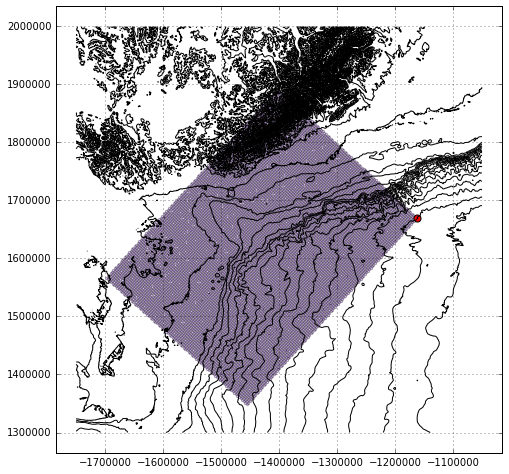

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')
ax.scatter(lon_s_grid, lat_s_grid, c='BlueViolet', s=5, alpha=0.3)
ax.scatter(lon_s_grid[0,-1], lat_s_grid[0,-1], c='r', s=50)
lon_s_grid.shape

# 4. Realistic Bathymetry

In [18]:
z_positive = functions_realistic.canyon_for_model(fluid_depth, extension, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

(87, 140)

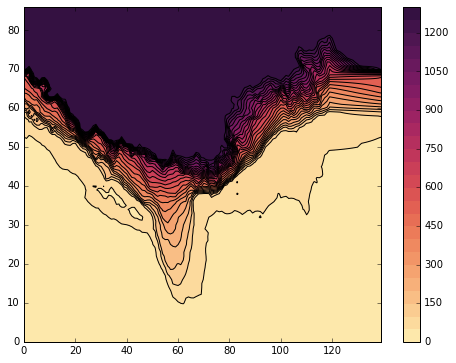

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cs = ax.contourf(z_positive, 25, cmap=cmo.cm.matter)
ax.contour(z_positive, 25, linestyles='solid', colors = 'k')
fig.colorbar(cs)
z_positive.shape

In [10]:
z_original, z_smoothed = functions_realistic.smooth_canyon(max_norm_depth_diff, smooth_factor, fluid_depth, extension, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

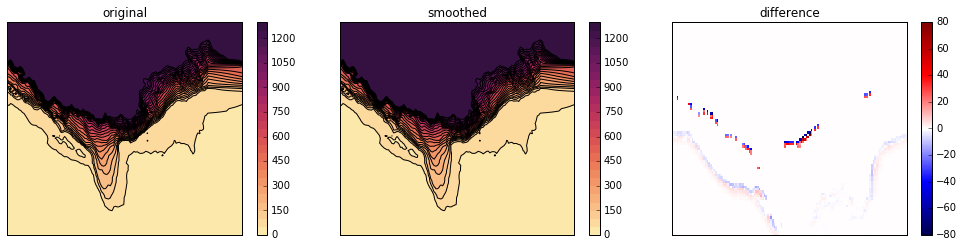

In [16]:
difference = np.subtract(z_smoothed, z_original)
fig, axes = plt.subplots(1,3,figsize=(14,3.5)); plt.tight_layout()
c0 = axes[0].contourf(z_original, 25, cmap = cmo.cm.matter)
c1 = axes[1].contourf(z_smoothed, 25, cmap = cmo.cm.matter)
c2 = axes[2].pcolormesh(difference, cmap = cm.seismic, vmin=-80, vmax=80)
axes[0].contour(z_original, 25, linestyles='solid', colors = 'k')
axes[1].contour(z_smoothed, 25, linestyles='solid', colors = 'k')
for cs, i, ttl in zip([c0, c1, c2], np.arange(3), ['original', 'smoothed', 'difference']):
    fig.colorbar(cs, ax = axes[i]); axes[i].set_title(ttl)
    axes[i].xaxis.set_visible(False); axes[i].yaxis.set_visible(False)

# 5. Domain Boundaries - Extended

In [25]:
dx = functions_grid.find_dx(lon_g_grid, lat_g_grid)
extension_m = dx * 1000 * extension

In [26]:
x_wall_ext = x_wall + extension_m
lon_s_corners_ext, lat_s_corners_ext = functions_grid.match_domain(x_wall_ext, y_wall, search_x)

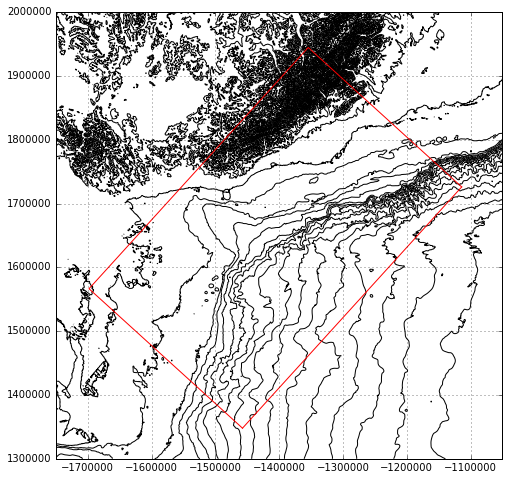

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')

ax.plot(lon_s_corners_ext, lat_s_corners_ext, 'r')
ax.plot(lon_s_corners_ext[0::3], lat_s_corners_ext[0::3], 'r')

# 6. Coordinate Grid - Extended

In [37]:
nx_extended = nx + extension
nx_extended, dx

(140, 3.6020365182825689)

In [38]:
lon_g_corners_ext, lat_g_corners_ext = functions_grid.transform_coords(lon_s_corners_ext, lat_s_corners_ext, 'SG')

In [53]:
def extend_grid(nx, ny, lon, lat, dx):
    
    from salishsea_tools import geo_tools

    lat2, lon2 = functions_grid.great_circle_points(lat[0], lon[0], lat[1], lon[1], nx)

    thelats = np.zeros((nx, ny))
    thelons = np.zeros_like(thelats)
    thelats[:,0] = lat2
    thelons[:,0] = lon2
    
    #dx = geo_tools.haversine(thelons[-1,0], thelats[-1,0], thelons[-2,0], thelats[-2,0])
    print(dx)
    
    angle = 0
    for j in range(1, ny):
        for i in range(0, nx-1):
            prevangle = angle
            bearing = functions_grid.calculate_initial_compass_bearing((thelats[i, j-1], thelons[i, j-1]), 
                                                        (thelats[i+1, j-1], thelons[i+1, j-1]))
            angle = bearing - 90.
            thelats[i,j], thelons[i,j] = functions_grid.step_forward(thelats[i,j-1], thelons[i,j-1], dx, angle)
        i = nx-1
        angle = 2*angle - prevangle
        thelats[i, j], thelons[i, j] = functions_grid.step_forward(thelats[i, j-1], thelons[i, j-1], dx, angle)
    dx2 = geo_tools.haversine(thelons[-1,1], thelats[-1,1], thelons[-2,1], thelats[-2,1])
    print(dx2)
    return thelons, thelats

In [54]:
lon_g_grid_ext, lat_g_grid_ext = extend_grid(nx_extended, ny, lon_g_corners_ext, lat_g_corners_ext, dx)

3.60203651828
2.29758925501


In [55]:
lon_s_grid_ext, lat_s_grid_ext = functions_grid.transform_coords(lon_g_grid_ext, lat_g_grid_ext, 'GS')

(140, 90)

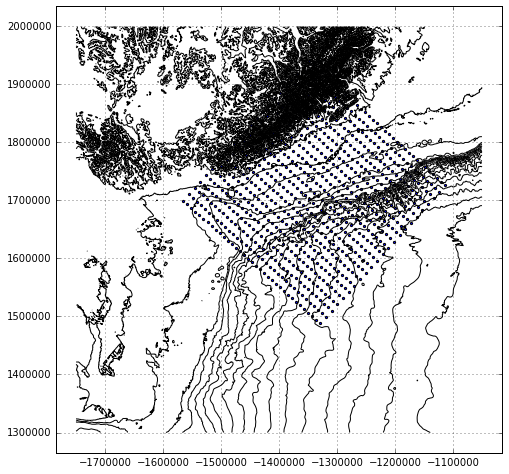

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')
ax.scatter(lon_s_grid_ext[::4,::4], lat_s_grid_ext[::4,::4], c='b', s=5)

lon_s_grid_ext.shape

# 7. Idealized Canyon

In [18]:
xsize = y_orig - 3 + 1
ysize = x_orig + extension - 3 + 1

In [19]:
x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall, y_wall)

bathymetry = functions_idealized.make_topo_smooth(y_edge, y_base, y_break, y_head, y_coast, cR, L,
                                             x, x_wall, w_break, w_mid, w_head, p,
                                             fluid_depth, z_bottom, z_break, z_wall)

(137, 87)

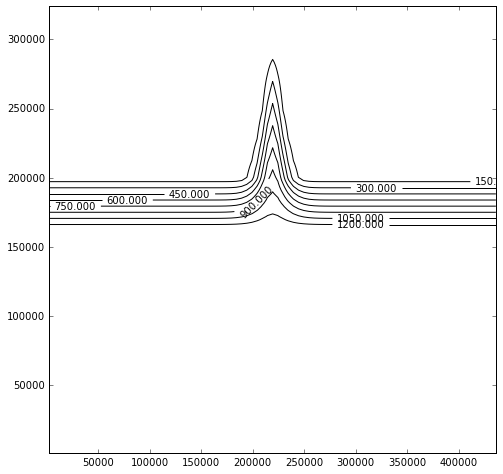

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cs = ax.contour(X, Y, bathymetry, 10, colors='k', linestyles='solid')
CS = ax.contour(X, Y, bathymetry, levels = [-1300, -80, -60, -40.1], colors='k',linestyles='solid')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)

bathymetry.shape